# Librerie 

In [1]:
#Base
import os
import pandas as pd
import numpy as np
import scipy as sp
import time
import sys
import matplotlib as plt
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import (
    accuracy_score,      # Accuracy = (TP + TN) / (TP + TN + FP + FN) → percentuale predizioni corrette
    precision_score,     # Precision = TP / (TP + FP) → quanti dei positivi predetti sono corretti
    recall_score,        # Recall = TP / (TP + FN) → quanti veri positivi sono stati trovati
    confusion_matrix,    # Matrice con: TP = veri positivi, FP = falsi positivi, FN = falsi negativi, TN = veri negativi
    f1_score             # F1 = 2 * (Precision * Recall) / (Precision + Recall) → misura che considera precision e recall
)

#Inserire nuova funzione 
sys.path.insert(2,'../Data') # per mette di caricare la funzone 
from preprocessing import preprocessing_diabetes
from preprocessing_v2 import preprocessing_diabetes_v2,combination_features





# Funzioni

In [2]:
#modello 
# Descrizione pricipali parametri KNeighborsClassifier() : 

# n_neighbors: num vicini per classificazione.
# weights: come pesare i vicini.
# metric: tipo di distanza usata (es. 'euclidean' o 'manhattan').
# algorithm: metodo usato per trovare i vicini (auto sceglie il migliore 
# in base ai dati passati attraverso fit). Vedere documentazione per varianti

from sklearn import metrics


def knn_grid_search(X_train_in, y_train_in, max_neighbors=5, num_partizioni=5):
    KNN = KNeighborsClassifier() 

    #Grid space

    search_space = {
    'n_neighbors': list(range(1, max_neighbors + 1)),  # ad esempio: [2, 3, 4, 5, k],
    #'weights': ['uniform'],
    'weights': ['uniform', 'distance'],
    # 'uniform' = tutti i vicini hanno lo stesso peso nel voto
    # 'distance' = i vicini più vicini hanno più peso (peso = 1 / distanza)
    'metric': ['euclidean', 'manhattan']
}


    #Grid search with cross-validation
    grid_search = GridSearchCV(
    KNN,
    param_grid = search_space,
    scoring = { "accuracy": "accuracy",
                "precision": "precision",
                "recall": "recall",
                "f1": "f1" },
    
    refit='f1', # metrica di valutazione
    cv= num_partizioni,   # fold cross-validation  #NO CAPITO  VERBOSE
    )
    
    #-----------------------------------------------------------------------------------------
    #COMMENTO 
    #Durante la Grid Search con cross-validation, per ogni combinazione di iperparametri
    # vengono calcolate e salvate tutte le metriche specificate (accuracy, precision, recall, f1)
    # su ciascuna fold della cross-validation. 
    # Il modello finale restituito è quello che massimizza la metrica indicata con 'refit' (f1),
    # e viene rifittato su tutto il training set con i migliori iperparametri trovati.
    #-----------------------------------------------------------------------------------------
   
    
    #Adattamento del modello ai dati di addestramento
    grid_search.fit(X_train_in, y_train_in)
    
    #-----------------------------------------------------------------------------------------
    #COMMENTO 
    # I valori medi delle metriche calcolate durante la cross-validation sono salvati in cv_results_.
     # Tuttavia, cv_results_ contiene i risultati per tutte le combinazioni di iperparametri testate.
     # Per ottenere i valori medi delle metriche relativi al modello migliore 
     # bisogna usare l'indice grid_search.best_index_ così da accedere alla riga corretta.
    #-----------------------------------------------------------------------------------------
 
    # CREIAMO UN DATAFRAME CON LE PERFORMANCE DEL MODELLO MIGLIORE da visualizzare in output
    best_index = grid_search.best_index_

    # 1.Estraggo le medie delle metriche per il modello migliore
    mean_accuracy = grid_search.cv_results_['mean_test_accuracy'][best_index]
    mean_precision = grid_search.cv_results_['mean_test_precision'][best_index]
    mean_recall = grid_search.cv_results_['mean_test_recall'][best_index]
    mean_f1 = grid_search.cv_results_['mean_test_f1'][best_index]

    # 2.Creo un DataFrame con le metriche medie della cross-validation per il modello migliore

    cv_metrics_best_model_df = pd.DataFrame(
        [[mean_accuracy, mean_precision, mean_recall, mean_f1]],
        columns=['Accuracy', 'Precision', 'Recall', 'f1'],
        index=['Performance Train']
    )
    #display(cv_metrics_best_model_df)

    
    KNN_Best= grid_search.best_estimator_    # modello con i migliori parametri, già fit
    Parameter_Best = grid_search.best_params_    # dizionario con i migliori parametri trovati

    
    return KNN_Best, Parameter_Best , cv_metrics_best_model_df


def evaluate_knn(knn_model, X_test, y_test, label='test'):
    start=time.time()
    y_pred = knn_model.predict(X_test)
    end=time.time()
    TempoEsecuzione = end - start
    accuracy = accuracy_score(y_test, y_pred)      
    precision = precision_score(y_test, y_pred)     
    recall = recall_score(y_test, y_pred)           
    f1 = f1_score(y_test, y_pred)                   
    
    # Creazione DataFrame performance 
    metrics_df = pd.DataFrame(
    data=[[accuracy, precision, recall, f1, TempoEsecuzione]],   # Riga di valori calcolati
    columns=['Accuracy', 'Precision', 'Recall', 'f1','Time'],  # Nomi delle colonne
    index=[label]                               # Etichetta della riga, es. 'PCA', 'Classico', ecc.
    )

    conf_mat=confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(conf_mat,
                        index=['Reali sani', 'Reali diabetici'],
                        columns=['Predetti sani', 'Predetti diabetici']

            )
    return metrics_df, cm_df, 




# Importazione dati

In [3]:
train_data= pd.read_csv('../Data/diabetes_train.csv')
test_data= pd.read_csv('../Data/diabetes_test.csv')

# Modelli con diversi preprocessing

### Preprocessing normale

,Accuracy,Precision,Recall,f1
Performance Train,0.969229,0.942917,0.938571,0.937319


,metric,n_neighbors,weights
PARAMETERS BEST KNN,manhattan,12,distance


,Accuracy,Precision,Recall,f1,Time
Performaramce Test,0.952381,0.894737,0.918919,0.906667,0.002946


,Predetti sani,Predetti diabetici
Reali sani,106,4
Reali diabetici,3,34


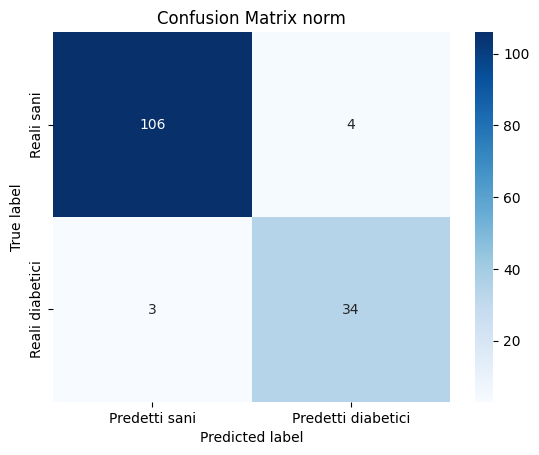

In [4]:
X_train_norm, X_test_norm, y_train_norm, y_test_norm = preprocessing_diabetes(train_data, test_data) 

knn_best_norm, best_params_norm, performance_train_df_norm = knn_grid_search(X_train_norm, y_train_norm, max_neighbors=30, num_partizioni=10)
display(performance_train_df_norm)  # visualizzazione delle performance del modello migliore

# risultati GridSearchCV
parameters_norm = pd.DataFrame([best_params_norm], index=["PARAMETERS BEST KNN"])
display(parameters_norm)

# Valutazione del modello sui dati di test
metrics_df_norm, conf_mat_norm = evaluate_knn(knn_best_norm, X_test_norm, y_test_norm, label='Performaramce Test')
display(metrics_df_norm)

# Visualizzazione della matrice di confusione
display(conf_mat_norm)  # come dataframe
sns.heatmap(conf_mat_norm, annot=True, fmt='d', cmap='Blues')  # visualizzazione con seaborn
plt.title('Confusion Matrix norm')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


### Preprocessing PCA 

,Accuracy,Precision,Recall,f1
Performance Train,0.965839,0.960298,0.904286,0.927443


,metric,n_neighbors,weights
PARAMETERS BEST KNN,euclidean,2,uniform


,Accuracy,Precision,Recall,f1,Time
Performance Test,0.931973,0.864865,0.864865,0.864865,0.006043


,Predetti sani,Predetti diabetici
Reali sani,105,5
Reali diabetici,5,32


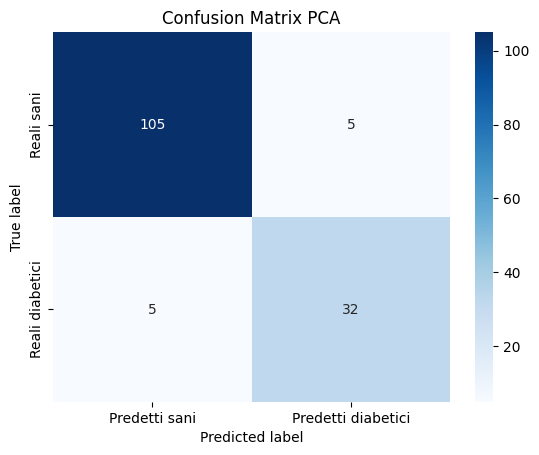

In [5]:
# PCA
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = preprocessing_diabetes(train_data, test_data, option='PCA') 

knn_best_PCA, best_params_PCA, performance_train_df_PCA = knn_grid_search(X_train_PCA, y_train_PCA, max_neighbors=30, num_partizioni=10)
display(performance_train_df_PCA)  # visualizzazione delle performance del modello migliore

# risultati GridSearchCV
parameters_PCA = pd.DataFrame([best_params_PCA], index=["PARAMETERS BEST KNN"])
display(parameters_PCA)

# Valutazione del modello sui dati di test
metrics_df_PCA, conf_mat_PCA = evaluate_knn(knn_best_PCA, X_test_PCA, y_test_PCA, label='Performance Test')
display(metrics_df_PCA)

# Visualizzazione della matrice di confusione
display(conf_mat_PCA)  # come dataframe
sns.heatmap(conf_mat_PCA, annot=True, fmt='d', cmap='Blues')  # visualizzazione con seaborn
plt.title('Confusion Matrix PCA')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



### Preprocessing No Correlation

,Accuracy,Precision,Recall,f1
Performance Train,0.965809,0.922183,0.951905,0.932943


,metric,n_neighbors,weights
PARAMETERS BEST KNN,manhattan,5,distance


,Accuracy,Precision,Recall,f1,Time
Performance Test,0.952381,0.894737,0.918919,0.906667,0.002826


,Predetti sani,Predetti diabetici
Reali sani,106,4
Reali diabetici,3,34


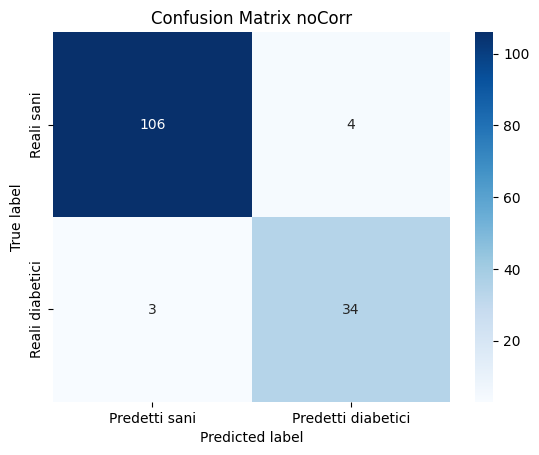

In [6]:
#No Correlation

X_train_noCorr, X_test_noCorr, y_train_noCorr, y_test_noCorr = preprocessing_diabetes(train_data, test_data, option='Delete') 

knn_best_noCorr, best_params_noCorr, performance_train_df_noCorr = knn_grid_search(X_train_noCorr, y_train_noCorr, max_neighbors=30, num_partizioni=10)
display(performance_train_df_noCorr)  # visualizzazione delle performance del modello migliore

# risultati GridSearchCV
parameters_noCorr = pd.DataFrame([best_params_noCorr], index=["PARAMETERS BEST KNN"])
display(parameters_noCorr)

# Valutazione del modello sui dati di test
metrics_df_noCorr, conf_mat_noCorr = evaluate_knn(knn_best_noCorr, X_test_noCorr, y_test_noCorr, label='Performance Test')
display(metrics_df_noCorr)

# Visualizzazione della matrice di confusione
display(conf_mat_noCorr)  # come dataframe
sns.heatmap(conf_mat_noCorr, annot=True, fmt='d', cmap='Blues')  # visualizzazione con seaborn
plt.title('Confusion Matrix noCorr')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### No Smoking

,Accuracy,Precision,Recall,f1
Performance Train,0.965868,0.925833,0.945238,0.932658


,metric,n_neighbors,weights
PARAMETERS BEST KNN,manhattan,4,distance


,Accuracy,Precision,Recall,f1,Time
Performance Test,0.945578,0.853659,0.945946,0.897436,0.002484


,Predetti sani,Predetti diabetici
Reali sani,104,6
Reali diabetici,2,35


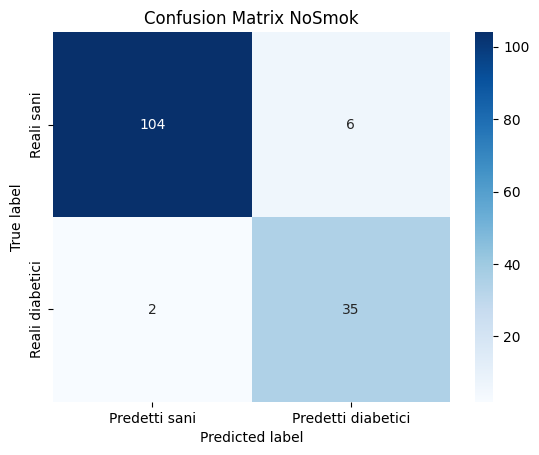

In [7]:
#No Smoking
X_train_NoSmok, X_test_NoSmok, y_train_NoSmok, y_test_NoSmok = preprocessing_diabetes(train_data, test_data) 

#Togliamo l'attributo 'smoking'

#Training set
colonne_da_tenere = []
for colonna in X_train_NoSmok.columns:
    if 'smoking' not in colonna:
        colonne_da_tenere.append(colonna)
        
X_train_NoSmok = X_train_NoSmok[colonne_da_tenere]


#Test set
colonne_da_tenere_test = []
for colonna in X_test_NoSmok.columns:
    if 'smoking' not in colonna:
        colonne_da_tenere_test.append(colonna)

X_test_NoSmok = X_test_NoSmok[colonne_da_tenere_test]


# modello 
knn_best_NoSmok, best_params_NoSmok, performance_train_df_NoSmok = knn_grid_search(X_train_NoSmok, y_train_NoSmok, max_neighbors=30, num_partizioni=10)
display(performance_train_df_NoSmok)  # visualizzazione delle performance del modello migliore

# risultati GridSearchCV
parameters_NoSmok = pd.DataFrame([best_params_NoSmok], index=["PARAMETERS BEST KNN"])
display(parameters_NoSmok)

# Valutazione del modello sui dati di test
metrics_df_NoSmok, conf_mat_NoSmok = evaluate_knn(knn_best_NoSmok, X_test_NoSmok, y_test_NoSmok, label='Performance Test')
display(metrics_df_NoSmok)

# Visualizzazione della matrice di confusione
display(conf_mat_NoSmok)  # come dataframe
sns.heatmap(conf_mat_NoSmok, annot=True, fmt='d', cmap='Blues')  # visualizzazione con seaborn
plt.title('Confusion Matrix NoSmok')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()




,ModelName,Accuracy,Precision,Recall,f1,metric,n_neighbors,weights
0,Normal,0.969229,0.942917,0.938571,0.937319,manhattan,12,distance
1,PCA,0.965839,0.960298,0.904286,0.927443,euclidean,2,uniform
2,No Correlation,0.965809,0.922183,0.951905,0.932943,manhattan,5,distance
3,No Smoking,0.965868,0.925833,0.945238,0.932658,manhattan,4,distance


,Accuracy,Precision,Recall,f1,Time
ModelName,,,,,
Normal,0.952381,0.894737,0.918919,0.906667,0.002946
PCA,0.931973,0.864865,0.864865,0.864865,0.006043
No Correlation,0.952381,0.894737,0.918919,0.906667,0.002826
No Smoking,0.945578,0.853659,0.945946,0.897436,0.002484


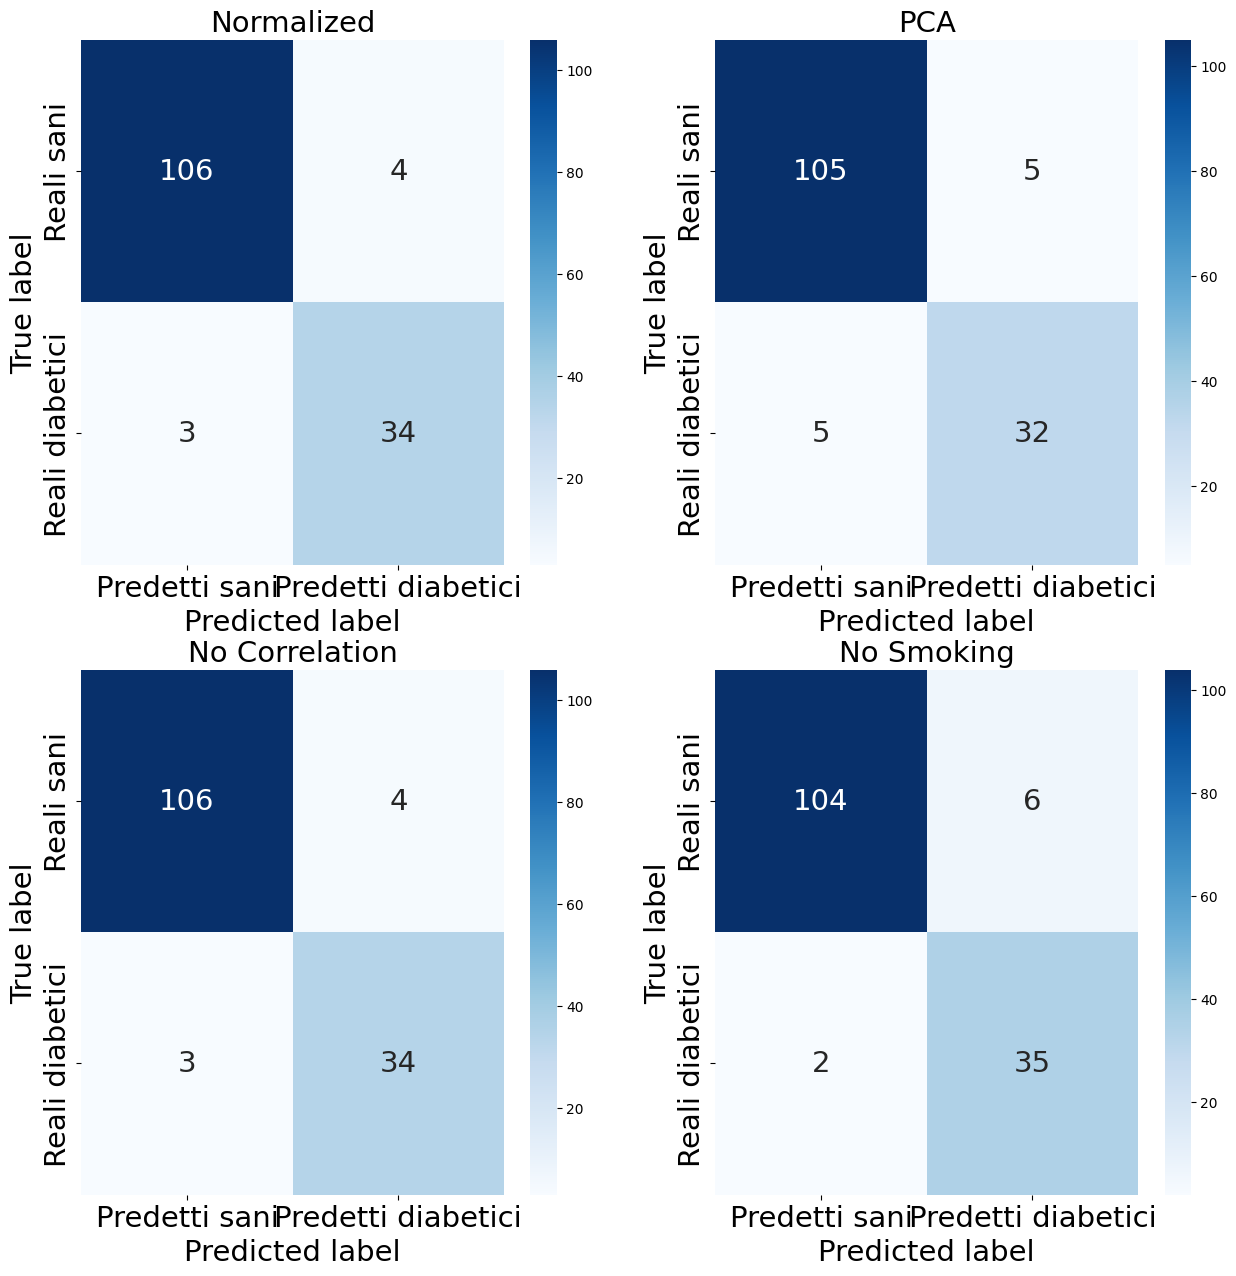

In [8]:
#PERFORMANCE TRAINING

# Creiamo copie temporanee per il confronto delle metriche di TRAINING
df_norm_test = performance_train_df_norm.reset_index(drop=True).copy()
df_norm_test['ModelName'] = 'Normal'

df_PCA_test = performance_train_df_PCA.reset_index(drop=True).copy()
df_PCA_test['ModelName'] = 'PCA'

df_noCorr_test = performance_train_df_noCorr.reset_index(drop=True).copy()
df_noCorr_test['ModelName'] = 'No Correlation'

df_NoSmok_test = performance_train_df_NoSmok.reset_index(drop=True).copy()
df_NoSmok_test['ModelName'] = 'No Smoking'

#ìConcateniamo copie 
performance_train_all = pd.concat([df_norm_test, df_PCA_test, df_noCorr_test, df_NoSmok_test], ignore_index=True)


performance_train_all = performance_train_all[['ModelName', 'Accuracy', 'Precision', 'Recall', 'f1']]
pperformance_train_all = performance_train_all.set_index('ModelName')

#display(performance_train_all)

#----------------------------------------------------------------------------------------------------

#PARAMETRI MODELLO
# Creiamo copie temporanee per confrontare i PARAMETRI dei modelli
parameters_norm_cp = parameters_norm.reset_index(drop=True).copy()
parameters_norm_cp['ModelName'] = 'Normal'

parameters_PCA_cp = parameters_PCA.reset_index(drop=True).copy()
parameters_PCA_cp['ModelName'] = 'PCA'

parameters_noCorr_cp = parameters_noCorr.reset_index(drop=True).copy()
parameters_noCorr_cp['ModelName'] = 'No Correlation'

parameters_NoSmok_cp = parameters_NoSmok.reset_index(drop=True).copy()
parameters_NoSmok_cp['ModelName'] = 'No Smoking'

# Concatenazione 
parameters_all = pd.concat([parameters_norm_cp, parameters_PCA_cp, parameters_noCorr_cp, parameters_NoSmok_cp], ignore_index=True)

parameters_all = parameters_all[['ModelName', 'metric', 'n_neighbors', 'weights']]
parameters_all = parameters_all.set_index('ModelName')


#display(parameters_all)

#----------------------------------------------------------------------------------------------------
# Unione delle performance e dei parametri

#1. Riporto 'ModelName' da indice a colonna sui PARAMETRI per fare il merge 
parameters_all_reset = parameters_all.reset_index()

# 2.Unisco performance e parametri usando 'ModelName' come chiave
df_combined = performance_train_all.merge(parameters_all_reset, on='ModelName')

display(df_combined)

#----------------------------------------------------------------------------------------------------

# PERFORMANCE TEST

# Creiamo copie temporanee per il confronto delle metriche di TEST
df_norm_test = metrics_df_norm.reset_index(drop=True).copy()
df_norm_test['ModelName'] = 'Normal'

df_PCA_test = metrics_df_PCA.reset_index(drop=True).copy()
df_PCA_test['ModelName'] = 'PCA'

df_noCorr_test = metrics_df_noCorr.reset_index(drop=True).copy()
df_noCorr_test['ModelName'] = 'No Correlation'

df_NoSmok_test = metrics_df_NoSmok.reset_index(drop=True).copy()
df_NoSmok_test['ModelName'] = 'No Smoking'

#Concateniamo
performance_test_all = pd.concat([df_norm_test, df_PCA_test, df_noCorr_test, df_NoSmok_test], ignore_index=True)

performance_test_all = performance_test_all[['ModelName', 'Accuracy', 'Precision', 'Recall', 'f1','Time']]
performance_test_all = performance_test_all.set_index('ModelName')

display(performance_test_all)

# MATRICI DI CONFUSIONE

conf_matrices = [conf_mat_norm, conf_mat_PCA, conf_mat_noCorr, conf_mat_NoSmok]
titles = ['Normalized', 'PCA', 'No Correlation', 'No Smoking']

fig, axes = plt.subplots(2, 2, figsize=(15, 15))  # (righe, colonne)


sns.heatmap(conf_matrices[0], annot=True, fmt='d', cmap='Blues', ax=axes[0,0], annot_kws={"size": 21})
axes[0,0].set_title(titles[0], fontsize=21)
axes[0,0].set_xlabel('Predicted label', fontsize=21)
axes[0,0].set_ylabel('True label', fontsize=21)
axes[0,0].tick_params(axis='both', labelsize=21)

sns.heatmap(conf_matrices[1], annot=True, fmt='d', cmap='Blues', ax=axes[0,1], annot_kws={"size": 21})
axes[0,1].set_title(titles[1], fontsize=21)
axes[0,1].set_xlabel('Predicted label', fontsize=21)
axes[0,1].set_ylabel('True label', fontsize=21)
axes[0,1].tick_params(axis='both', labelsize=21)

sns.heatmap(conf_matrices[2], annot=True, fmt='d', cmap='Blues', ax=axes[1,0], annot_kws={"size": 21})
axes[1,0].set_title(titles[2], fontsize=21)
axes[1,0].set_xlabel('Predicted label', fontsize=21)
axes[1,0].set_ylabel('True label', fontsize=21)
axes[1,0].tick_params(axis='both', labelsize=21)

sns.heatmap(conf_matrices[3], annot=True, fmt='d', cmap='Blues', ax=axes[1,1], annot_kws={"size": 21})
axes[1,1].set_title(titles[3], fontsize=21)
axes[1,1].set_xlabel('Predicted label', fontsize=21)
axes[1,1].set_ylabel('True label', fontsize=21)
axes[1,1].tick_params(axis='both', labelsize=21)

plt.show()

# PREPROCESSIONG 2 oversample=True,augment=True

In [9]:
#Normal
X_train_norm2, X_test_norm2, y_train_norm2, y_test_norm2 = preprocessing_diabetes_v2(train_data, test_data,oversample=True,augment=True) 
knn_best_norm2, best_params_norm2, performance_train_df_norm2 = knn_grid_search(X_train_norm2, y_train_norm2, max_neighbors=30, num_partizioni=10)
# risultati GridSearchCV
parameters_norm2 = pd.DataFrame([best_params_norm2], index=["PARAMETERS BEST KNN"])
# Valutazione del modello sui dati di test
metrics_df_norm2, conf_mat_norm2 = evaluate_knn(knn_best_norm2, X_test_norm2, y_test_norm2, label='Performaramce Test')

# PCA
X_train_PCA2, X_test_PCA2, y_train_PCA2, y_test_PCA2 = preprocessing_diabetes_v2(train_data, test_data,oversample=True,augment=True)
knn_best_PCA2, best_params_PCA2, performance_train_df_PCA2 = knn_grid_search(X_train_PCA2, y_train_PCA2, max_neighbors=30, num_partizioni=10)
# risultati GridSearchCV
parameters_PCA2 = pd.DataFrame([best_params_PCA2], index=["PARAMETERS BEST KNN"])
# Valutazione del modello sui dati di test
metrics_df_PCA2, conf_mat_PCA2 = evaluate_knn(knn_best_PCA2, X_test_PCA2, y_test_PCA2, label='Performance Test')

#No Correlation
X_train_noCorr2, X_test_noCorr2, y_train_noCorr2, y_test_noCorr2 = preprocessing_diabetes_v2(train_data, test_data,oversample=True,augment=True)
knn_best_noCorr2, best_params_noCorr2, performance_train_df_noCorr2 = knn_grid_search(X_train_noCorr2, y_train_noCorr2, max_neighbors=30, num_partizioni=10)
# risultati GridSearchCV
parameters_noCorr2 = pd.DataFrame([best_params_noCorr2], index=["PARAMETERS BEST KNN"])
# Valutazione del modello sui dati di test
metrics_df_noCorr2, conf_mat_noCorr2 = evaluate_knn(knn_best_noCorr2, X_test_noCorr2, y_test_noCorr2, label='Performance Test')

#No Smoking
X_train_NoSmok2, X_test_NoSmok2, y_train_NoSmok2, y_test_NoSmok2 = preprocessing_diabetes_v2(train_data, test_data,oversample=True,augment=True)
#Togliamo l'attributo 'smoking'

#Training set
colonne_da_tenere2 = []
for colonna in X_train_NoSmok2.columns:
    if 'smoking' not in colonna:
        colonne_da_tenere2.append(colonna)
        
X_train_NoSmok2 = X_train_NoSmok2[colonne_da_tenere2]

#Test set
colonne_da_tenere_test2 = []
for colonna in X_test_NoSmok2.columns:
    if 'smoking' not in colonna:
        colonne_da_tenere_test2.append(colonna)

X_test_NoSmok2 = X_test_NoSmok2[colonne_da_tenere_test2]
# modello 
knn_best_NoSmok2, best_params_NoSmok2, performance_train_df_NoSmok2 = knn_grid_search(X_train_NoSmok2, y_train_NoSmok2, max_neighbors=30, num_partizioni=10)
parameters_NoSmok2 = pd.DataFrame([best_params_NoSmok2], index=["PARAMETERS BEST KNN"])
# Valutazione del modello sui dati di test
metrics_df_NoSmok2, conf_mat_NoSmok2 = evaluate_knn(knn_best_NoSmok2, X_test_NoSmok2, y_test_NoSmok2, label='Performance Test')
 

,ModelName,Accuracy,Precision,Recall,f1,metric,n_neighbors,weights
0,Normal,0.980669,0.975635,0.986364,0.980819,manhattan,2,uniform
1,PCA,0.979532,0.977749,0.981818,0.979564,manhattan,2,uniform
2,No Correlation,0.981792,0.977773,0.986311,0.981918,manhattan,2,uniform
3,No Smoking,0.976110,0.969212,0.984038,0.976373,manhattan,2,uniform


,Accuracy,Precision,Recall,f1,Time
ModelName,,,,,
Normal,0.945578,0.891892,0.891892,0.891892,0.014535
PCA,0.945578,0.871795,0.918919,0.894737,0.014098
No Correlation,0.959184,0.897436,0.945946,0.921053,0.013259
No Smoking,0.979592,0.947368,0.972973,0.960000,0.010957


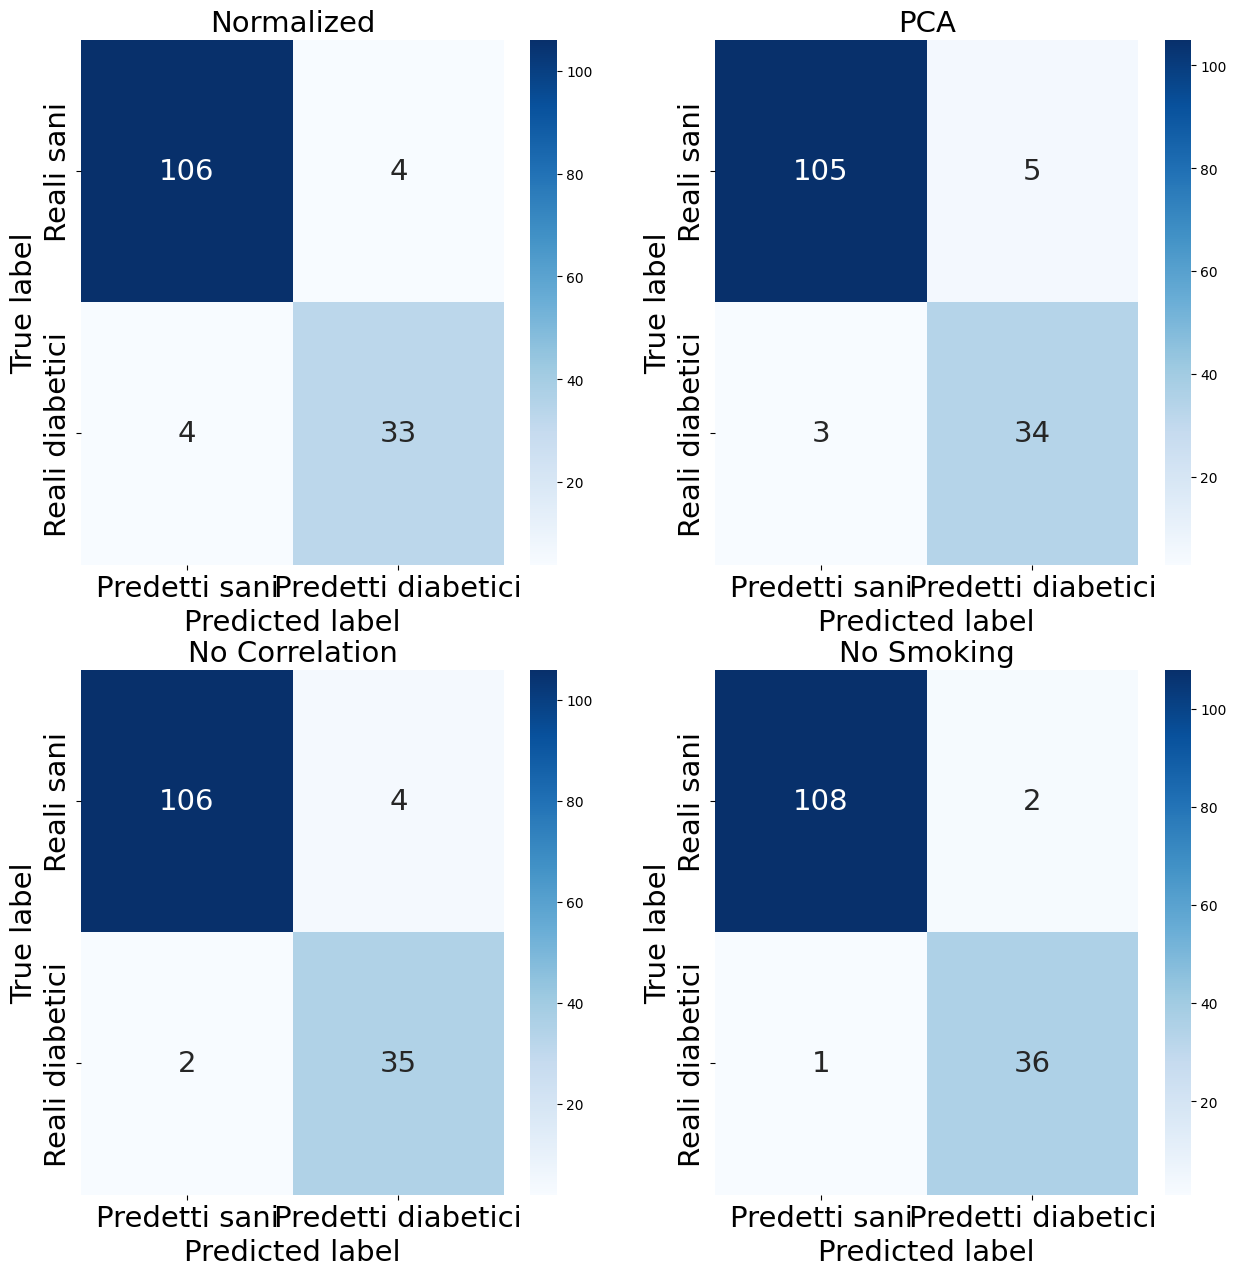

In [10]:


#SECONDO PREPROCESSING
#-----------------------------------------------------------------------------------------------------------stampa

#PERFORMANCE TRAINING
# Creiamo copie temporanee per il confronto delle metriche di TRAINING
df_norm_test2 = performance_train_df_norm2.reset_index(drop=True).copy()
df_norm_test2['ModelName'] = 'Normal'

df_PCA_test2 = performance_train_df_PCA2.reset_index(drop=True).copy()
df_PCA_test2['ModelName'] = 'PCA'

df_noCorr_test2 = performance_train_df_noCorr2.reset_index(drop=True).copy()
df_noCorr_test2['ModelName'] = 'No Correlation'

df_NoSmok_test2 = performance_train_df_NoSmok2.reset_index(drop=True).copy()
df_NoSmok_test2['ModelName'] = 'No Smoking'

#ìConcateniamo copie 
performance_train_all2 = pd.concat([df_norm_test2, df_PCA_test2, df_noCorr_test2, df_NoSmok_test2], ignore_index=True)

performance_train_all2 = performance_train_all2[['ModelName', 'Accuracy', 'Precision', 'Recall', 'f1']]
performance_train_all2 = performance_train_all2.set_index('ModelName')

#display(performance_train_all2)

#----------------------------------------------------------------------------------------------------

#PARAMETRI MODELLO
# Creiamo copie temporanee per confrontare i PARAMETRI dei modelli
parameters_norm_cp2 = parameters_norm2.reset_index(drop=True).copy()
parameters_norm_cp2['ModelName'] = 'Normal'

parameters_PCA_cp2 = parameters_PCA2.reset_index(drop=True).copy()
parameters_PCA_cp2['ModelName'] = 'PCA'

parameters_noCorr_cp2 = parameters_noCorr2.reset_index(drop=True).copy()
parameters_noCorr_cp2['ModelName'] = 'No Correlation'

parameters_NoSmok_cp2 = parameters_NoSmok2.reset_index(drop=True).copy()
parameters_NoSmok_cp2['ModelName'] = 'No Smoking'

# Concatenazione 
parameters_all2 = pd.concat([parameters_norm_cp2, parameters_PCA_cp2, parameters_noCorr_cp2, parameters_NoSmok_cp2], ignore_index=True)

parameters_all2 = parameters_all2[['ModelName', 'metric', 'n_neighbors', 'weights']]
parameters_all2 = parameters_all2.set_index('ModelName')

#display(parameters_all2)

#----------------------------------------------------------------------------------------------------
# Unione delle performance e dei parametri

#1. Riporto 'ModelName' da indice a colonna sui PARAMETRI per fare il merge 
parameters_all_reset2 = parameters_all2.reset_index()

# 2.Unisco performance e parametri usando 'ModelName' come chiave
df_combined2 = performance_train_all2.merge(parameters_all_reset2, on='ModelName')

display(df_combined2)

#----------------------------------------------------------------------------------------------------

# PERFORMANCE TEST

# Creiamo copie temporanee per il confronto delle metriche di TEST
df_norm_test2 = metrics_df_norm2.reset_index(drop=True).copy()
df_norm_test2['ModelName'] = 'Normal'

df_PCA_test2 = metrics_df_PCA2.reset_index(drop=True).copy()
df_PCA_test2['ModelName'] = 'PCA'

df_noCorr_test2 = metrics_df_noCorr2.reset_index(drop=True).copy()
df_noCorr_test2['ModelName'] = 'No Correlation'

df_NoSmok_test2 = metrics_df_NoSmok2.reset_index(drop=True).copy()
df_NoSmok_test2['ModelName'] = 'No Smoking'

#Concateniamo
performance_test_all2 = pd.concat([df_norm_test2, df_PCA_test2, df_noCorr_test2, df_NoSmok_test2], ignore_index=True)

performance_test_all2 = performance_test_all2[['ModelName', 'Accuracy', 'Precision', 'Recall', 'f1','Time']]
performance_test_all2 = performance_test_all2.set_index('ModelName')

display(performance_test_all2)

# MATRICI DI CONFUSIONE

conf_matrices2 = [conf_mat_norm2, conf_mat_PCA2, conf_mat_noCorr2, conf_mat_NoSmok2]
titles2 = ['Normalized', 'PCA', 'No Correlation', 'No Smoking']

fig2, axes2 = plt.subplots(2, 2, figsize=(15, 15))  # (righe, colonne)

sns.heatmap(conf_matrices2[0], annot=True, fmt='d', cmap='Blues', ax=axes2[0,0], annot_kws={"size": 21})
axes2[0,0].set_title(titles2[0], fontsize=21)
axes2[0,0].set_xlabel('Predicted label', fontsize=21)
axes2[0,0].set_ylabel('True label', fontsize=21)
axes2[0,0].tick_params(axis='both', labelsize=21)

sns.heatmap(conf_matrices2[1], annot=True, fmt='d', cmap='Blues', ax=axes2[0,1], annot_kws={"size": 21})
axes2[0,1].set_title(titles2[1], fontsize=21)
axes2[0,1].set_xlabel('Predicted label', fontsize=21)
axes2[0,1].set_ylabel('True label', fontsize=21)
axes2[0,1].tick_params(axis='both', labelsize=21)

sns.heatmap(conf_matrices2[2], annot=True, fmt='d', cmap='Blues', ax=axes2[1,0], annot_kws={"size": 21})
axes2[1,0].set_title(titles2[2], fontsize=21)
axes2[1,0].set_xlabel('Predicted label', fontsize=21)
axes2[1,0].set_ylabel('True label', fontsize=21)
axes2[1,0].tick_params(axis='both', labelsize=21)

sns.heatmap(conf_matrices2[3], annot=True, fmt='d', cmap='Blues', ax=axes2[1,1], annot_kws={"size": 21})
axes2[1,1].set_title(titles2[3], fontsize=21)
axes2[1,1].set_xlabel('Predicted label', fontsize=21)
axes2[1,1].set_ylabel('True label', fontsize=21)
axes2[1,1].tick_params(axis='both', labelsize=21)

plt.show()



# PREPROCESSIONG 2 oversample=True,augment=False

In [11]:
#Normal
X_train_norm3, X_test_norm3, y_train_norm3, y_test_norm3 = preprocessing_diabetes_v2(train_data, test_data, oversample=True, augment=False) 
knn_best_norm3, best_params_norm3, performance_train_df_norm3 = knn_grid_search(X_train_norm3, y_train_norm3, max_neighbors=30, num_partizioni=10)
parameters_norm3 = pd.DataFrame([best_params_norm3], index=["PARAMETERS BEST KNN"])
metrics_df_norm3, conf_mat_norm3 = evaluate_knn(knn_best_norm3, X_test_norm3, y_test_norm3, label='Performaramce Test')

# PCA
X_train_PCA3, X_test_PCA3, y_train_PCA3, y_test_PCA3 = preprocessing_diabetes_v2(train_data, test_data, oversample=True, augment=False)
knn_best_PCA3, best_params_PCA3, performance_train_df_PCA3 = knn_grid_search(X_train_PCA3, y_train_PCA3, max_neighbors=30, num_partizioni=10)
parameters_PCA3 = pd.DataFrame([best_params_PCA3], index=["PARAMETERS BEST KNN"])
metrics_df_PCA3, conf_mat_PCA3 = evaluate_knn(knn_best_PCA3, X_test_PCA3, y_test_PCA3, label='Performance Test')

#No Correlation
X_train_noCorr3, X_test_noCorr3, y_train_noCorr3, y_test_noCorr3 = preprocessing_diabetes_v2(train_data, test_data, oversample=True, augment=False)
knn_best_noCorr3, best_params_noCorr3, performance_train_df_noCorr3 = knn_grid_search(X_train_noCorr3, y_train_noCorr3, max_neighbors=30, num_partizioni=10)
parameters_noCorr3 = pd.DataFrame([best_params_noCorr3], index=["PARAMETERS BEST KNN"])
metrics_df_noCorr3, conf_mat_noCorr3 = evaluate_knn(knn_best_noCorr3, X_test_noCorr3, y_test_noCorr3, label='Performance Test')

#No Smoking
X_train_NoSmok3, X_test_NoSmok3, y_train_NoSmok3, y_test_NoSmok3 = preprocessing_diabetes_v2(train_data, test_data, oversample=True, augment=False)
# Togliamo l'attributo 'smoking'

#Training set
colonne_da_tenere3 = []
for colonna in X_train_NoSmok3.columns:
    if 'smoking' not in colonna:
        colonne_da_tenere3.append(colonna)
        
X_train_NoSmok3 = X_train_NoSmok3[colonne_da_tenere3]

#Test set
colonne_da_tenere_test3 = []
for colonna in X_test_NoSmok3.columns:
    if 'smoking' not in colonna:
        colonne_da_tenere_test3.append(colonna)

X_test_NoSmok3 = X_test_NoSmok3[colonne_da_tenere_test3]
# modello 
knn_best_NoSmok3, best_params_NoSmok3, performance_train_df_NoSmok3 = knn_grid_search(X_train_NoSmok3, y_train_NoSmok3, max_neighbors=30, num_partizioni=10)
parameters_NoSmok3 = pd.DataFrame([best_params_NoSmok3], index=["PARAMETERS BEST KNN"])
# Valutazione del modello sui dati di test
metrics_df_NoSmok3, conf_mat_NoSmok3 = evaluate_knn(knn_best_NoSmok3, X_test_NoSmok3, y_test_NoSmok3, label='PerformPerformance Test')


,ModelName,Accuracy,Precision,Recall,f1,metric,n_neighbors,weights
0,Normal,0.981792,0.969214,0.995455,0.982070,manhattan,2,uniform
1,PCA,0.979532,0.965205,0.995455,0.979973,manhattan,2,uniform
2,No Correlation,0.976097,0.967084,0.986311,0.976371,manhattan,2,uniform
3,No Smoking,0.977234,0.971342,0.984091,0.977523,manhattan,2,uniform


,Accuracy,Precision,Recall,f1,Time
ModelName,,,,,
Normal,0.959184,0.878049,0.972973,0.923077,0.007659
PCA,0.959184,0.878049,0.972973,0.923077,0.007687
No Correlation,0.965986,0.880952,1.000000,0.936709,0.007724
No Smoking,0.965986,0.944444,0.918919,0.931507,0.006542


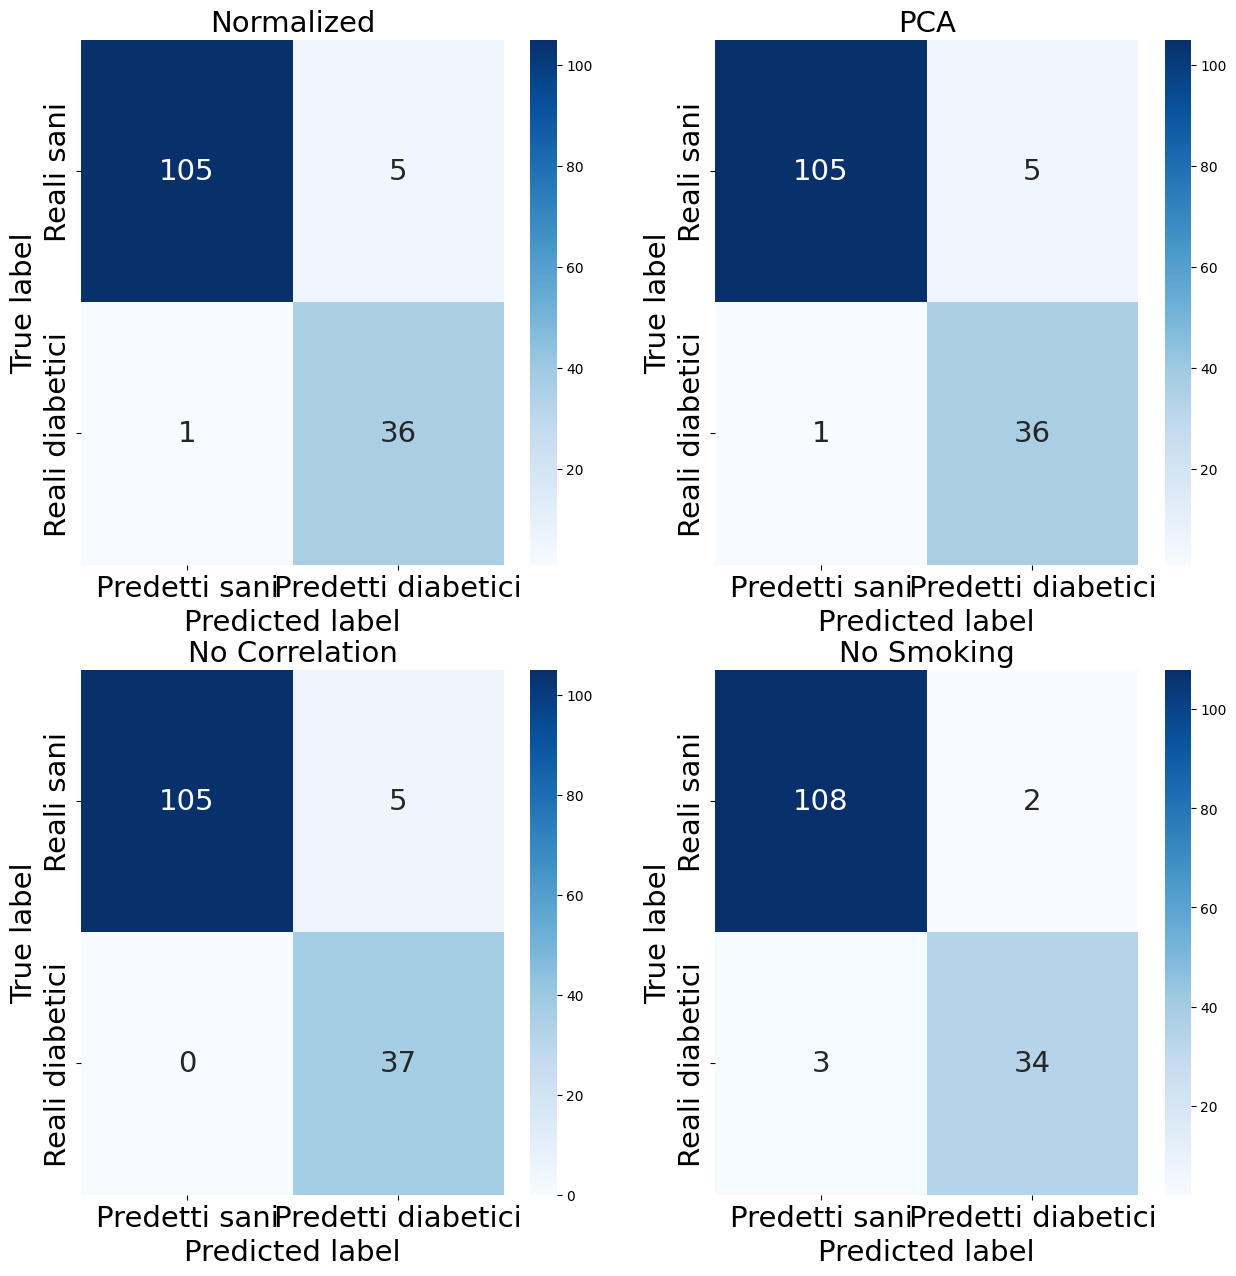

In [12]:

#TERZO PREPROCESSING
#-----------------------------------------------------------------------------------------------------------stampa

#PERFORMANCE TRAINING
# Creiamo copie temporanee per il confronto delle metriche di TRAINING
df_norm_test3 = performance_train_df_norm3.reset_index(drop=True).copy()
df_norm_test3['ModelName'] = 'Normal'

df_PCA_test3 = performance_train_df_PCA3.reset_index(drop=True).copy()
df_PCA_test3['ModelName'] = 'PCA'

df_noCorr_test3 = performance_train_df_noCorr3.reset_index(drop=True).copy()
df_noCorr_test3['ModelName'] = 'No Correlation'

df_NoSmok_test3 = performance_train_df_NoSmok3.reset_index(drop=True).copy()
df_NoSmok_test3['ModelName'] = 'No Smoking'

#ìConcateniamo copie 
performance_train_all3 = pd.concat([df_norm_test3, df_PCA_test3, df_noCorr_test3, df_NoSmok_test3], ignore_index=True)

performance_train_all3 = performance_train_all3[['ModelName', 'Accuracy', 'Precision', 'Recall', 'f1']]
performance_train_all3 = performance_train_all3.set_index('ModelName')

#display(performance_train_all3)

#----------------------------------------------------------------------------------------------------

#PARAMETRI MODELLO
# Creiamo copie temporanee per confrontare i PARAMETRI dei modelli
parameters_norm_cp3 = parameters_norm3.reset_index(drop=True).copy()
parameters_norm_cp3['ModelName'] = 'Normal'

parameters_PCA_cp3 = parameters_PCA3.reset_index(drop=True).copy()
parameters_PCA_cp3['ModelName'] = 'PCA'

parameters_noCorr_cp3 = parameters_noCorr3.reset_index(drop=True).copy()
parameters_noCorr_cp3['ModelName'] = 'No Correlation'

parameters_NoSmok_cp3 = parameters_NoSmok3.reset_index(drop=True).copy()
parameters_NoSmok_cp3['ModelName'] = 'No Smoking'

# Concatenazione 
parameters_all3 = pd.concat([parameters_norm_cp3, parameters_PCA_cp3, parameters_noCorr_cp3, parameters_NoSmok_cp3], ignore_index=True)

parameters_all3 = parameters_all3[['ModelName', 'metric', 'n_neighbors', 'weights']]
parameters_all3 = parameters_all3.set_index('ModelName')

#display(parameters_all3)

#----------------------------------------------------------------------------------------------------
# Unione delle performance e dei parametri

#1. Riporto 'ModelName' da indice a colonna sui PARAMETRI per fare il merge 
parameters_all_reset3 = parameters_all3.reset_index()

# 2.Unisco performance e parametri usando 'ModelName' come chiave
df_combined3 = performance_train_all3.merge(parameters_all_reset3, on='ModelName')

display(df_combined3)

#----------------------------------------------------------------------------------------------------

# PERFORMANCE TEST

# Creiamo copie temporanee per il confronto delle metriche di TEST
df_norm_test3 = metrics_df_norm3.reset_index(drop=True).copy()
df_norm_test3['ModelName'] = 'Normal'

df_PCA_test3 = metrics_df_PCA3.reset_index(drop=True).copy()
df_PCA_test3['ModelName'] = 'PCA'

df_noCorr_test3 = metrics_df_noCorr3.reset_index(drop=True).copy()
df_noCorr_test3['ModelName'] = 'No Correlation'

df_NoSmok_test3 = metrics_df_NoSmok3.reset_index(drop=True).copy()
df_NoSmok_test3['ModelName'] = 'No Smoking'

#Concateniamo
performance_test_all3 = pd.concat([df_norm_test3, df_PCA_test3, df_noCorr_test3, df_NoSmok_test3], ignore_index=True)

performance_test_all3 = performance_test_all3[['ModelName', 'Accuracy', 'Precision', 'Recall', 'f1','Time']]
performance_test_all3 = performance_test_all3.set_index('ModelName')

display(performance_test_all3)

# MATRICI DI CONFUSIONE

conf_matrices3 = [conf_mat_norm3, conf_mat_PCA3, conf_mat_noCorr3, conf_mat_NoSmok3]
titles3 = ['Normalized', 'PCA', 'No Correlation', 'No Smoking']

fig3, axes3 = plt.subplots(2, 2, figsize=(15, 15))  # (righe, colonne)

sns.heatmap(conf_matrices3[0], annot=True, fmt='d', cmap='Blues', ax=axes3[0,0], annot_kws={"size": 21})
axes3[0,0].set_title(titles3[0], fontsize=21)
axes3[0,0].set_xlabel('Predicted label', fontsize=21)
axes3[0,0].set_ylabel('True label', fontsize=21)
axes3[0,0].tick_params(axis='both', labelsize=21)

sns.heatmap(conf_matrices3[1], annot=True, fmt='d', cmap='Blues', ax=axes3[0,1], annot_kws={"size": 21})
axes3[0,1].set_title(titles3[1], fontsize=21)
axes3[0,1].set_xlabel('Predicted label', fontsize=21)
axes3[0,1].set_ylabel('True label', fontsize=21)
axes3[0,1].tick_params(axis='both', labelsize=21)

sns.heatmap(conf_matrices3[2], annot=True, fmt='d', cmap='Blues', ax=axes3[1,0], annot_kws={"size": 21})
axes3[1,0].set_title(titles3[2], fontsize=21)
axes3[1,0].set_xlabel('Predicted label', fontsize=21)
axes3[1,0].set_ylabel('True label', fontsize=21)
axes3[1,0].tick_params(axis='both', labelsize=21)

sns.heatmap(conf_matrices3[3], annot=True, fmt='d', cmap='Blues', ax=axes3[1,1], annot_kws={"size": 21})
axes3[1,1].set_title(titles3[3], fontsize=21)
axes3[1,1].set_xlabel('Predicted label', fontsize=21)
axes3[1,1].set_ylabel('True label', fontsize=21)
axes3[1,1].tick_params(axis='both', labelsize=21)

plt.show()
